In [10]:
##############################################################################
#                            LINEAR REGRESSION
##############################################################################

########## TABLE OF CONTENTS #############

# 1. Data read in
# 2. Data quality check
# 3. Data preparation
# 4. Model training - OLS Approach
# 5. Model evaluation
# 6. Model validation
# 7. Ridge regression
# 8. Lasso regression

# Dataset -> Prostate -> Taken from https://hastie.su.domains/ElemStatLearn/
###########################################


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # Visualization
import seaborn as sns #Visualization
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['font.size'] =14
plt.rcParams['font.weight']= 'bold'
import scipy 
from scipy import stats 
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import math
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from scipy import stats
import warnings
warnings.filterwarnings("ignore")


1. DATA READ IN

In [11]:
df = pd.read_csv("Prostate.txt", delimiter='\t', index_col=0)

# For this exercise I will drop the Train column and create my own Train/Test flag (50%/50%)

df = df.drop(columns=['train'], axis=1)
df['TrainTestFlag'] = 0
df.iloc[pd.Series(df.index).sample(frac=0.5, random_state=1234), df.columns.get_loc('TrainTestFlag')] = 1
print("Train vs Test sample")
print(df['TrainTestFlag'].value_counts())
print("")

df.shape
df.info()
df

# PREDICTORS (columns 1--8)
# lcavol 
# lweight
# age
# lbph
# svi
# lcp
# gleason
# pgg45

# OUTCOME (column 9)
# lpsa - Traget variable

# train/test indicator (column 10)

Train vs Test sample
TrainTestFlag
0    49
1    48
Name: count, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Index: 97 entries, 1 to 97
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lcavol         97 non-null     float64
 1   lweight        97 non-null     float64
 2   age            97 non-null     int64  
 3   lbph           97 non-null     float64
 4   svi            97 non-null     int64  
 5   lcp            97 non-null     float64
 6   gleason        97 non-null     int64  
 7   pgg45          97 non-null     int64  
 8   lpsa           97 non-null     float64
 9   TrainTestFlag  97 non-null     int64  
dtypes: float64(5), int64(5)
memory usage: 8.3 KB


,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,TrainTestFlag
1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,0
2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,0
3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,1
4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,0
5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,0
...,...,...,...,...,...,...,...,...,...,...
93,2.830268,3.876396,68,-1.386294,1,1.321756,7,60,4.385147,1
94,3.821004,3.896909,44,-1.386294,1,2.169054,7,40,4.684443,0
95,2.907447,3.396185,52,-1.386294,1,2.463853,7,10,5.143124,1
96,2.882564,3.773910,68,1.558145,1,1.558145,7,80,5.477509,0


2. DATA QUALITY CHECK

Checking duplicates
0

Univariate Analysis


,Feature,Feature Type,# Records,# Zero's,% Zero's,# Missing,% Missing,Minimum,Mean,Median,Maximum,Skewness,Kurtosis,Normality (p > 0.05)
0,lcavol,float64,97.0,0.0,0.00,0.0,0.0,-1.35,1.35,1.45,3.82,-0.25,-0.52,0.266
0,lweight,float64,97.0,0.0,0.00,0.0,0.0,2.37,3.63,3.62,4.78,0.06,0.52,0.511
0,age,int64,97.0,0.0,0.00,0.0,0.0,41.00,63.87,65.00,79.00,-0.83,1.16,0.001
0,lbph,float64,97.0,0.0,0.00,0.0,0.0,-1.39,0.10,0.30,2.33,0.13,-1.75,0.000
0,svi,int64,97.0,76.0,7.84,0.0,0.0,0.00,0.22,0.00,1.00,1.40,-0.05,0.000
0,lcp,float64,97.0,0.0,0.00,0.0,0.0,-1.39,-0.18,-0.80,2.90,0.73,-0.96,0.000
0,gleason,int64,97.0,0.0,0.00,0.0,0.0,6.00,6.75,7.00,9.00,1.26,2.67,0.000
0,pgg45,int64,97.0,35.0,3.61,0.0,0.0,0.00,24.38,15.00,100.00,0.97,-0.27,0.002
0,lpsa,float64,97.0,0.0,0.00,0.0,0.0,-0.43,2.48,2.59,5.58,-0.00,0.59,0.470
0,TrainTestFlag,int64,97.0,49.0,5.05,0.0,0.0,0.00,0.49,0.00,1.00,0.02,-2.04,0.000





Correlation Analysis - Train Sample


,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
lcavol,1.000000,0.207830,0.225301,-0.037113,0.614791,0.769900,0.467622,0.508121,0.751959
lweight,0.207830,1.000000,0.354593,0.550605,0.082247,0.065943,-0.061265,-0.039065,0.310415
age,0.225301,0.354593,1.000000,0.196346,0.136680,0.147862,0.233915,0.279339,0.069999
lbph,-0.037113,0.550605,0.196346,1.000000,-0.096322,-0.083467,-0.050907,-0.077299,0.067040
svi,0.614791,0.082247,0.136680,-0.096322,1.000000,0.653910,0.279073,0.378702,0.608400
lcp,0.769900,0.065943,0.147862,-0.083467,0.653910,1.000000,0.492971,0.583876,0.547490
gleason,0.467622,-0.061265,0.233915,-0.050907,0.279073,0.492971,1.000000,0.787323,0.310582
pgg45,0.508121,-0.039065,0.279339,-0.077299,0.378702,0.583876,0.787323,1.000000,0.274427
lpsa,0.751959,0.310415,0.069999,0.067040,0.608400,0.547490,0.310582,0.274427,1.000000


,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
lcavol,1.000000,0.207830,0.225301,-0.037113,0.614791,0.769900,0.467622,0.508121,0.751959
lweight,0.207830,1.000000,0.354593,0.550605,0.082247,0.065943,-0.061265,-0.039065,0.310415
age,0.225301,0.354593,1.000000,0.196346,0.136680,0.147862,0.233915,0.279339,0.069999
lbph,-0.037113,0.550605,0.196346,1.000000,-0.096322,-0.083467,-0.050907,-0.077299,0.067040
svi,0.614791,0.082247,0.136680,-0.096322,1.000000,0.653910,0.279073,0.378702,0.608400
lcp,0.769900,0.065943,0.147862,-0.083467,0.653910,1.000000,0.492971,0.583876,0.547490
gleason,0.467622,-0.061265,0.233915,-0.050907,0.279073,0.492971,1.000000,0.787323,0.310582
pgg45,0.508121,-0.039065,0.279339,-0.077299,0.378702,0.583876,0.787323,1.000000,0.274427
lpsa,0.751959,0.310415,0.069999,0.067040,0.608400,0.547490,0.310582,0.274427,1.000000




Train Sample - Correlation of Independent Features v. Target
----------------------------------------------------------------------------------------------------
Correlation of pred. feature lcavol: 0.75
Correlation of pred. feature lweight: 0.31
Correlation of pred. feature age: 0.07
Correlation of pred. feature lbph: 0.07
Correlation of pred. feature svi: 0.61
Correlation of pred. feature lcp: 0.55
Correlation of pred. feature gleason: 0.31
Correlation of pred. feature pgg45: 0.27
----------------------------------------------------------------------------------------------------


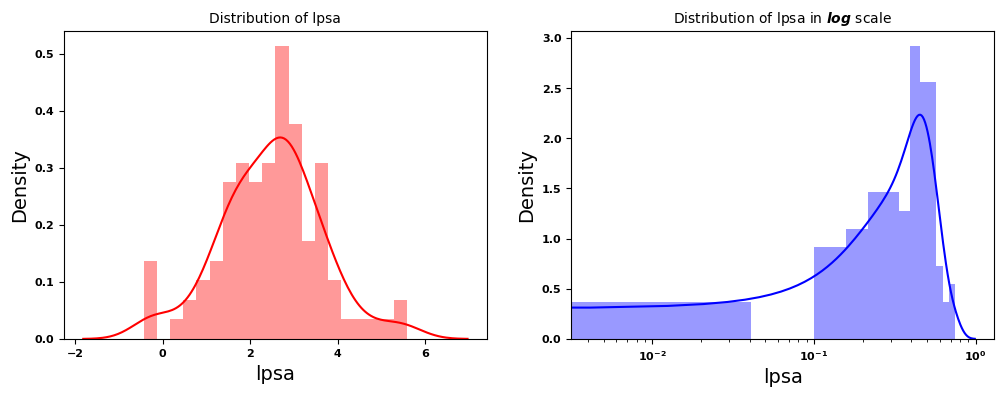

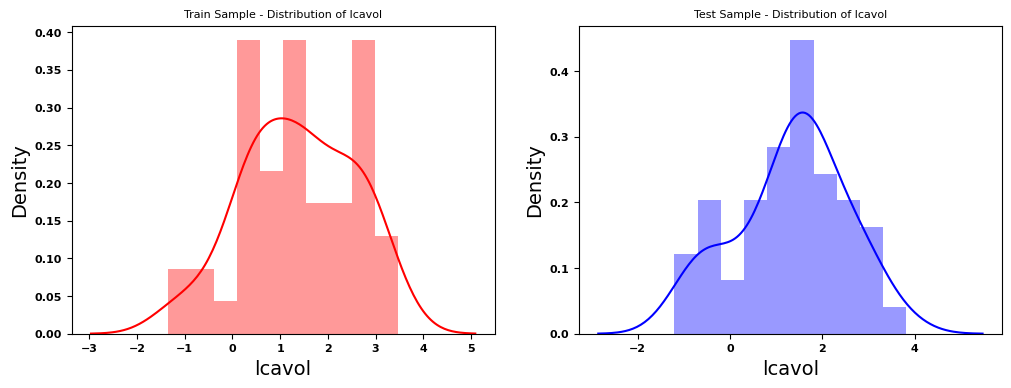

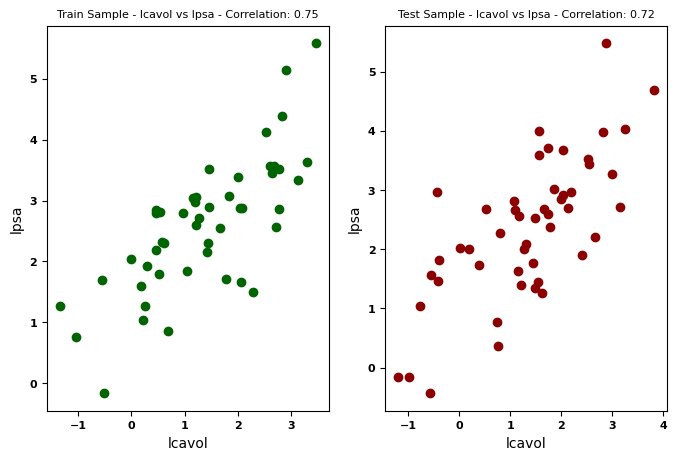

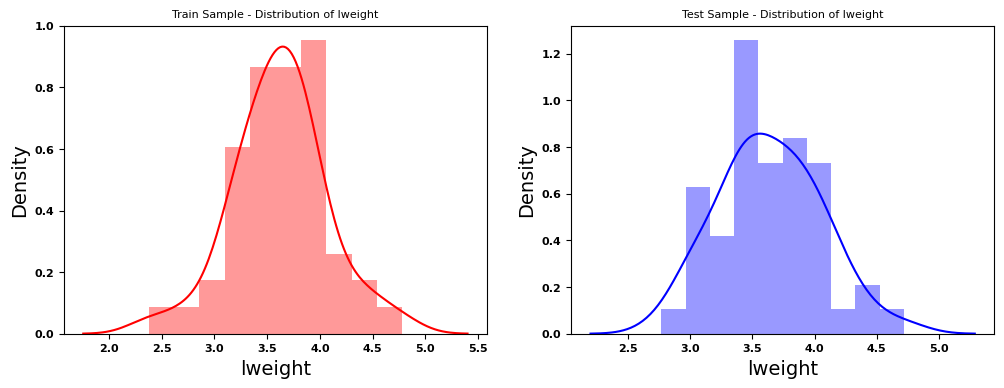

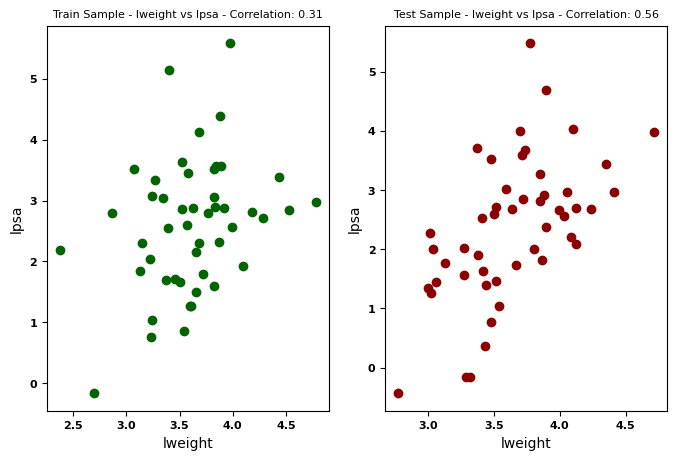

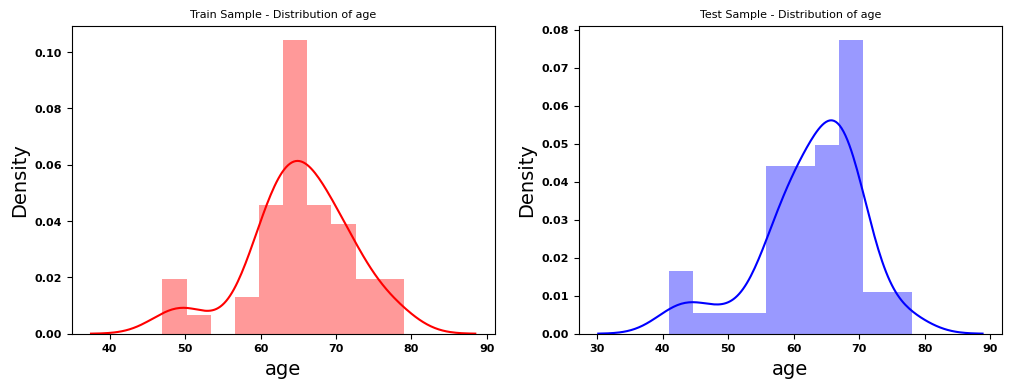

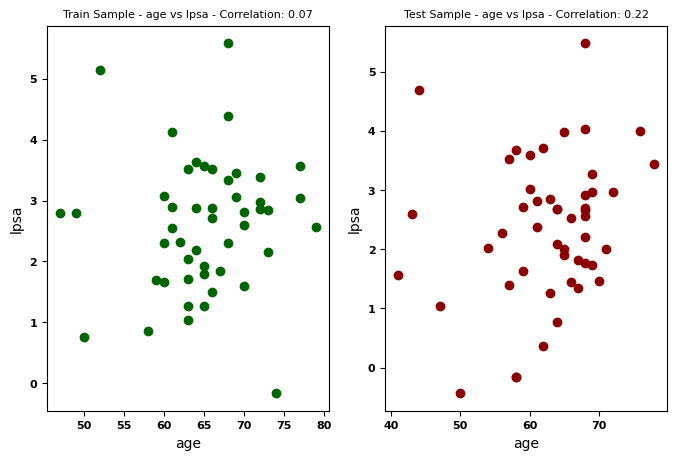

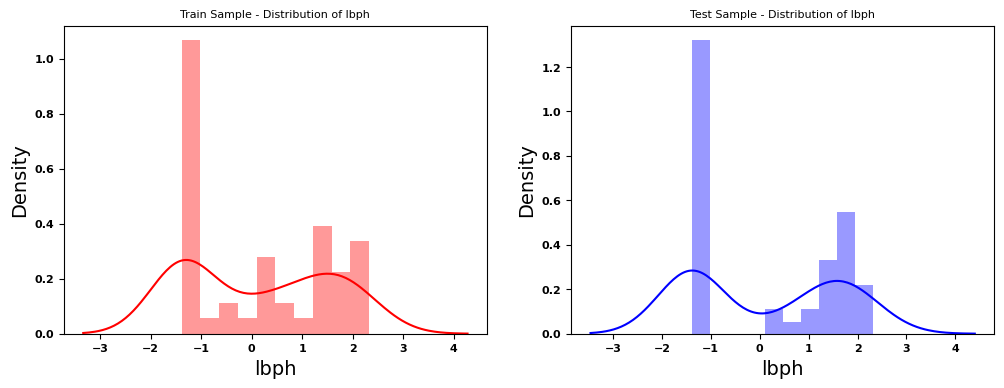

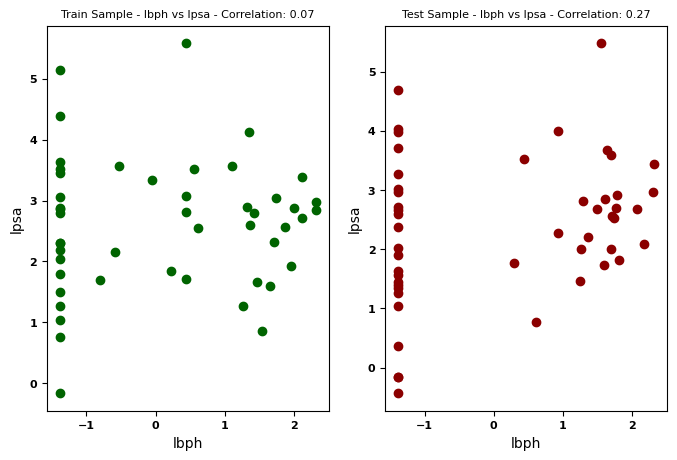

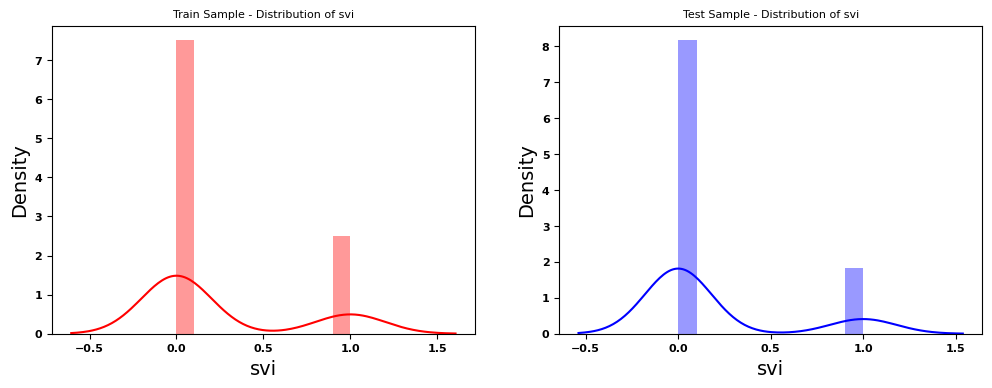

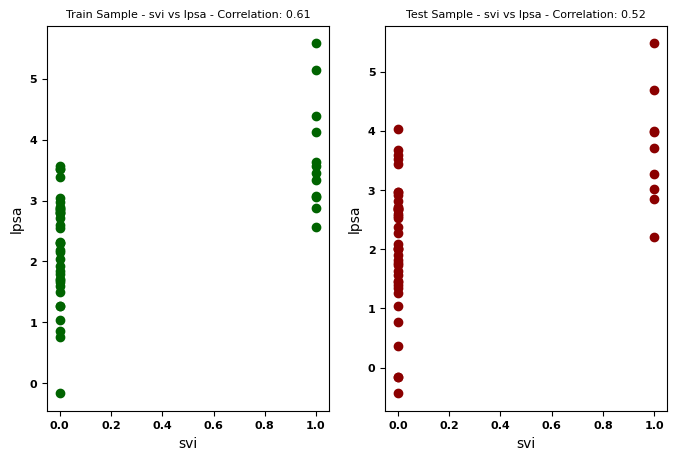

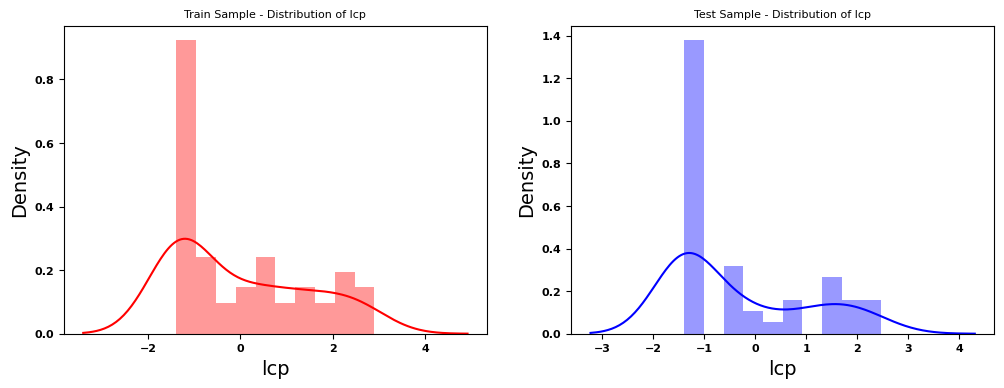

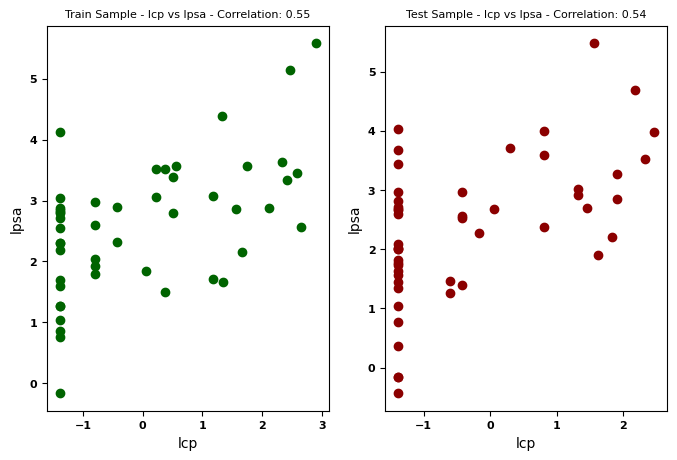

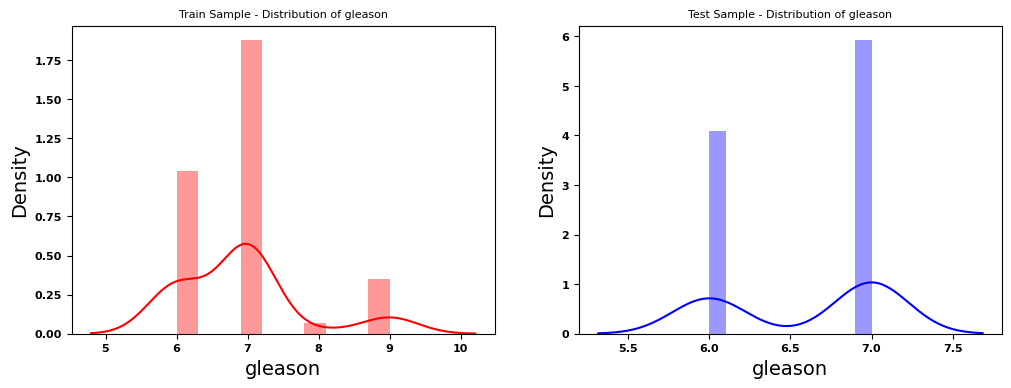

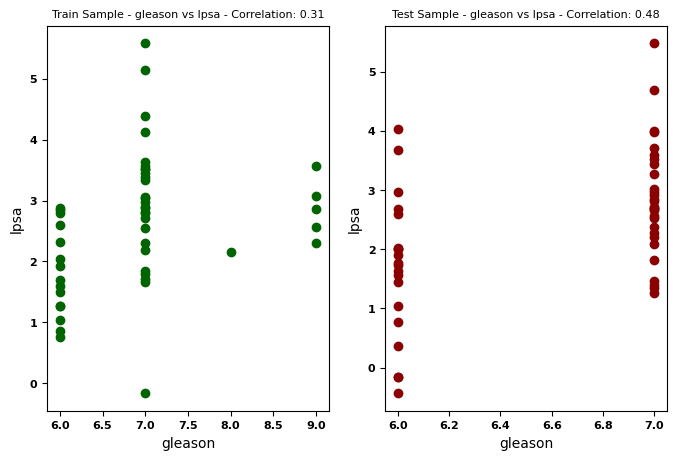

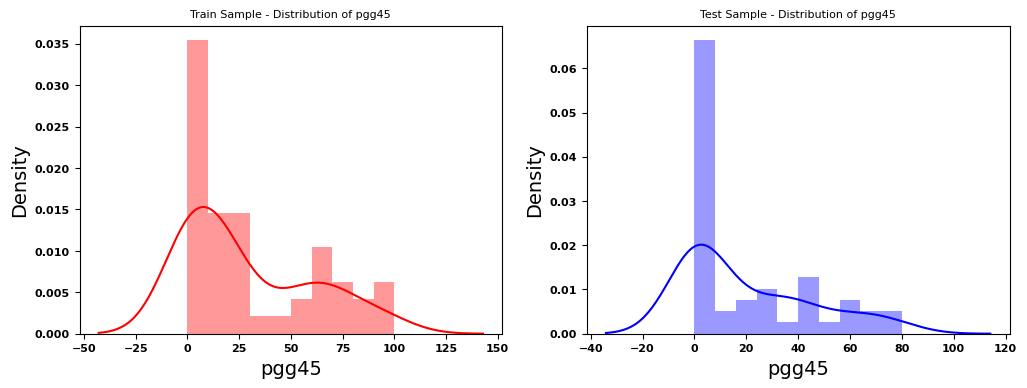

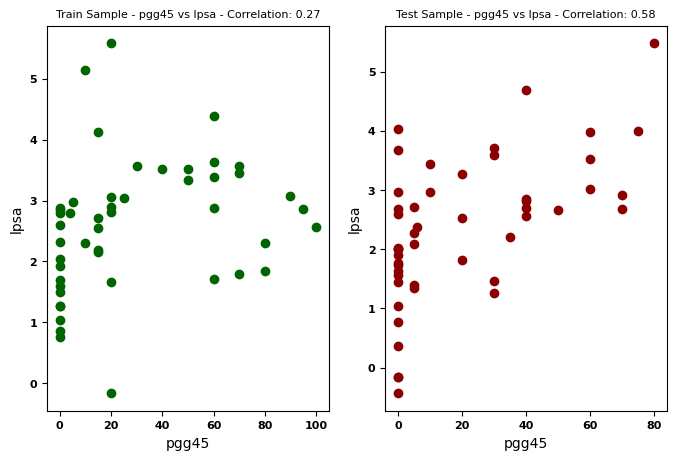

In [12]:
# Check for exact duplicates
print("Checking duplicates")
print(df.duplicated(keep=False).sum())
print("")
# Univariate Analysis
print("Univariate Analysis")
chars = df.columns

d = pd.DataFrame(index = [0],columns=['Feature','Feature Type','# Records',"# Zero's","% Zero's","# Missing","% Missing","Minimum", "Mean", "Median", "Maximum", "Skewness","Kurtosis","Normality (p > 0.05)"])
d.to_csv('univariateAnalysis.csv')      

notApplicable = "N/A"
for z in range(len(chars)):
    a = pd.read_csv('univariateAnalysis.csv',index_col=0)  
    if(df[chars[z]].dtype !='object'):
        k2, p = stats.normaltest(df[chars[z]])
        dd = pd.DataFrame({'Feature':[chars[z]],
                            'Feature Type':df[chars[z]].dtype,
                            "# Records":len(df),
                            "# Zero's": (df[chars[z]] == 0).sum(),
                            "% Zero's" : round((df[chars[z]] == 0).sum()/df.size*100,2),
                            "# Missing" : (df[chars[z]].isna()).sum(),
                            "% Missing" : round((df[chars[z]].isna()).sum()/df.size*100,2),
                            "Minimum" : round(df[chars[z]].min(),2),
                            "Mean" : round(df[chars[z]].mean(),2),
                            "Median" : round(df[chars[z]].median(),2),
                            "Maximum" : round(df[chars[z]].max(),2),
                            "Skewness" : round(df[chars[z]].skew(),2), #Positive Skewness -> LEFT SKEW -> -> Threshold is -0.5 < x < 0.5
                            "Kurtosis" : round(df[chars[z]].kurt(),2), #Negative Kurtosis -> FAT TAILS -> -> Threshold is 3
                            "Normality (p > 0.05)" : round(p,3)}
                            )
        s = pd.concat([a, dd])
        s = s.dropna()
        s.to_csv('univariateAnalysis.csv')

    else:
        dd = pd.DataFrame({'Feature':[chars[z]],
                    'Feature Type':df[chars[z]].dtype,
                    "# Records": len(df),
                    "# Zero's": (df[chars[z]] == 0).sum(),
                    "% Zero's" : round((df[chars[z]] == 0).sum()/len(df)*100,1),
                    "# Missing" : (df[chars[z]].isna()).sum(),
                    "% Missing" : round((df[chars[z]].isna()).sum()/df.size*100,1),
                    "Minimum" : [notApplicable],
                    "Mean" : [notApplicable],
                    "Median" : [notApplicable],
                    "Maximum" : [notApplicable],
                    "Skewness" : [notApplicable],
                    "Kurtosis" : [notApplicable],
                    "Normality (p > 0.05)" : [notApplicable]}
                    )

        s = pd.concat([a, dd])
        s = s.dropna()
        s.to_csv('univariateAnalysis.csv')
display(s)
print("")
# Distribution of target variable
f= plt.figure(figsize=(12,4))
ax=f.add_subplot(121)
ax.tick_params(axis='both', which='major', labelsize=8)
sns.distplot(df['lpsa'],bins=20,color='r',ax=ax)
ax.set_title('Distribution of lpsa',fontsize = 10)

ax=f.add_subplot(122)
ax.tick_params(axis='both', which='major', labelsize=8)
sns.distplot(np.log10(df['lpsa']),bins=20,color='b',ax=ax)
ax.set_title('Distribution of lpsa in $log$ scale',fontsize = 10)
ax.set_xscale('log');
print("")

# Split Train vs Test -> 50% vs 50%
train = df.loc[df['TrainTestFlag'] == 1]
test = df.loc[df['TrainTestFlag'] == 0]

# Correlation
print("")
print("Correlation Analysis - Train Sample")
ds = train.drop(columns=['TrainTestFlag'], axis=1)
corr = ds.corr()
display(corr)
display(corr.style.background_gradient(cmap='coolwarm'))
print("")


chars = list(df.columns)
chars.remove("TrainTestFlag")
chars.remove("lpsa")

for z in range(len(chars)):
    train_corr = round(train[chars[z]].corr(train['lpsa']),2)
    test_corr = round(test[chars[z]].corr(test['lpsa']),2)

    f= plt.figure(figsize=(12,4))
    ax=f.add_subplot(121)
    ax.tick_params(axis='both', which='major', labelsize=8)
    sns.distplot(train[chars[z]],bins=10,color='r',ax=ax)
    ax.set_title('Train Sample - Distribution of '+chars[z], fontsize = 8)

    ax=f.add_subplot(122)
    ax.tick_params(axis='both', which='major', labelsize=8)
    sns.distplot(test[chars[z]],bins=10,color='b',ax=ax)
    ax.set_title('Test Sample - Distribution of '+chars[z], fontsize = 8)


    fig = plt.figure()
    
    ax1 = fig.add_subplot(121)
    ax1.tick_params(axis='both', which='major', labelsize=8)
    ax1.scatter(x=train[chars[z]],
                      y=train['lpsa'],
                      c='DarkGreen')
    ax1.set_title("Train Sample - "+chars[z]+" vs lpsa - Correlation: "+str(train_corr), fontsize=8)
    ax1.set_xlabel(chars[z], fontsize = 10)
    ax1.set_ylabel("lpsa", fontsize = 10)
    ax1 = fig.add_subplot(122)
    ax1.tick_params(axis='both', which='major', labelsize=8)
    ax1.scatter(x=test[chars[z]],
                      y=test['lpsa'],
                      c='DarkRed')
    ax1.set_title("Test Sample - "+chars[z]+" vs lpsa - Correlation: "+str(test_corr), fontsize=8)    
    ax1.set_xlabel(chars[z], fontsize = 10)
    ax1.set_ylabel("lpsa", fontsize = 10)

print("")
print("Train Sample - Correlation of Independent Features v. Target")
print("-"*100)
for z in range(len(chars)):
    print("Correlation of pred. feature "+chars[z]+": "+str(round(train[chars[z]].corr(train['lpsa']),2)))
print("-"*100)

# # Violin plot of chars vs. lpsa
# f = plt.figure(figsize=(14,6))
# ax = f.add_subplot(121)
# sns.violinplot(x=chars[z], y='lpsa',data=train,palette='Wistia',ax=ax)
# ax.set_title('Train Sample - Violin plot of '+ chars[z]+' vs lpsa')

# f = plt.figure(figsize=(14,6))
# ax = f.add_subplot(121)
# sns.violinplot(x=chars[z], y='lpsa',data=test,palette='Wistia',ax=ax)
# ax.set_title('Test Sample - Violin plot of '+ chars[z]+' vs lpsa')


3. DATA PREPARATION

In [14]:
# No need to do any dummy variable transformation
# No need to log transform the target variable

# Consider the Train and Test Samples
trainSample = train.copy()
testSample = test.copy()

# Columns to drop
colsToDrop = ['lpsa','TrainTestFlag'] 
X_Train = trainSample.drop(columns = colsToDrop, axis=1)
X_Test = testSample.drop(columns = colsToDrop, axis=1)

# Scale Train Sample Predictive Features
print("Scale Train Sample Features")
if True:
    cols = X_Train.columns
    for i in range(len(cols)):
        print(cols[i])
        # Z-Score using scipy 
        X_Train[cols[i]] = stats.zscore(X_Train[cols[i]]) 
        # Check the standardization has been successful
        print("Mean: "+str(round(X_Train[cols[i]].mean(),2)))
        print("St. Dev: "+str(round(X_Train[cols[i]].std(),2)))

Y_Train= trainSample['lpsa'].values
print("")
# Scale Test Sample Predictive Features
print("Scale Train Sample Features")
if True:
    cols = X_Test.columns
    # Feautures scaling
    for i in range(len(cols)):
        print(cols[i])
        # Z-Score using scipy 
        X_Test[cols[i]] = stats.zscore(X_Test[cols[i]]) 
        # Check the normalization has been successful
        # Check the standardization has been successful
        print("Mean: "+str(round(X_Test[cols[i]].mean(),2)))
        print("St. Dev: "+str(round(X_Test[cols[i]].std(),2)))
Y_Test= testSample['lpsa'].values

print("")

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, 3 to 97
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lcavol         48 non-null     float64
 1   lweight        48 non-null     float64
 2   age            48 non-null     int64  
 3   lbph           48 non-null     float64
 4   svi            48 non-null     int64  
 5   lcp            48 non-null     float64
 6   gleason        48 non-null     int64  
 7   pgg45          48 non-null     int64  
 8   lpsa           48 non-null     float64
 9   TrainTestFlag  48 non-null     int64  
dtypes: float64(5), int64(5)
memory usage: 4.1 KB
None
Scale Train Sample Features


NameError: name 'X_Train' is not defined

4. MODEL TRAINING - OLS APPROACH

In [ ]:
# Columns to drop
colsToDrop = ['lpsa','TrainTestFlag','age','lbph','pgg45','lcp'] 
X_Train = trainSample.drop(columns = colsToDrop, axis=1)
X_Test = testSample.drop(columns = colsToDrop, axis=1)

#Train Model and produce results
X_Train = sm.add_constant(X_Train, prepend=False)

model = sm.OLS(Y_Train,X_Train)
result = model.fit()
display(result.summary())

# Correlation
print("")
print("Correlation Analysis")
ds = X_Train.drop(columns=['const'], axis=1)
corr = ds.corr()
display(corr)
display(corr.style.background_gradient(cmap='coolwarm'))
print("")


# Coefficient / Std Error = Z-Score
###########################################################################################

# Correlation of Independent Features v. Target
# ----------------------------------------------------------------------------------------------------
# Correlation of pred. feature lcavol: 0.75
# Correlation of pred. feature lweight: 0.31
# Correlation of pred. feature age: 0.07
# Correlation of pred. feature lbph: 0.07
# Correlation of pred. feature svi: 0.61
# Correlation of pred. feature lcp: 0.55
# Correlation of pred. feature gleason: 0.31
# Correlation of pred. feature pgg45: 0.27



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     18.18
Date:                Sun, 05 May 2024   Prob (F-statistic):           8.27e-09
Time:                        22:52:42   Log-Likelihood:                -48.039
No. Observations:                  48   AIC:                             106.1
Df Residuals:                      43   BIC:                             115.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lcavol         0.5329      0.123      4.317      0.000       0.284       0.782
lweight        0.4155      0.236      1.758      0.086      -0.061       0.892
svi            0.6163      0.295      2.093      0.042       0.022       1.210
gleason       -0.0192      0.134     -0.143      0.887      -0.290       0.251
const          0.3419      1.311      0.261      0.795      -2.301       2.985
==============================================================================
Omnibus:                        0.421   Durbin-Watson:                   1.430
Prob(Omnibus):                  0.810   Jarque-Bera (JB):                0.410
Skew:                          -0.204   Prob(JB):                        0.815
Kurtosis:                       2.806   Cond. No.                         106.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


Correlation Analysis


,lcavol,lweight,svi,gleason
lcavol,1.000000,0.207830,0.614791,0.467622
lweight,0.207830,1.000000,0.082247,-0.061265
svi,0.614791,0.082247,1.000000,0.279073
gleason,0.467622,-0.061265,0.279073,1.000000


,lcavol,lweight,svi,gleason
lcavol,1.000000,0.207830,0.614791,0.467622
lweight,0.207830,1.000000,0.082247,-0.061265
svi,0.614791,0.082247,1.000000,0.279073
gleason,0.467622,-0.061265,0.279073,1.000000


In [ ]:
# Step 0: drop columns from predictive set
colsToDrop = ['lpsa','TrainTestFlag','age','lbph','pgg45','lcp'] 
X_Train = trainSample.drop(columns = colsToDrop, axis=1)
X_Test = testSample.drop(columns = colsToDrop, axis=1)

# Step 1: add x0 =1 to dataset
X_train_0 = np.c_[np.ones((X_Train.shape[0],1)),X_Train]
X_test_0 = np.c_[np.ones((X_Test.shape[0],1)),X_Test]


# Step2: build model
theta = np.matmul(np.linalg.inv( np.matmul(X_train_0.T,X_train_0) ), np.matmul(X_train_0.T,Y_Train)) 

# The parameters for linear regression model
parameter = ['theta_'+str(i) for i in range(X_train_0.shape[1])]
columns = ['intersect:x_0=1'] + list(X_Train.columns.values)
parameter_df = pd.DataFrame({'Parameter':parameter,'Columns':columns,'theta':theta})

# Scikit Learn module
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_Train,Y_Train) # Note: x_0 =1 is no need to add, sklearn will take care of it.


#Parameter
sk_theta = [lin_reg.intercept_]+list(lin_reg.coef_)
parameter_df = parameter_df.join(pd.Series(sk_theta, name='Sklearn_theta'))
parameter_df

,Parameter,Columns,theta,Sklearn_theta
0,theta_0,intersect:x_0=1,0.341857,0.341857
1,theta_1,lcavol,0.532938,0.532938
2,theta_2,lweight,0.415487,0.415487
3,theta_3,svi,0.616345,0.616345
4,theta_4,gleason,-0.019215,-0.019215


5. MODEL EVALUATION

In [ ]:
# Normal equation
y_pred_norm =  np.matmul(X_train_0,theta)

#Evaluvation: MSE
J_mse = np.sum((y_pred_norm - Y_Train)**2)/ X_train_0.shape[0]

# R_square 
sse = np.sum((y_pred_norm - Y_Train)**2)
sst = np.sum((Y_Train - Y_Train.mean())**2)
R_square = 1 - (sse/sst)
print('Train Sample - The Mean Square Error(MSE) or J(theta) is: ',J_mse)
print('Train Sample - R square obtain for normal equation method is :',R_square)

print("-"*50)

# Normal equation
y_pred_norm =  np.matmul(X_test_0,theta)

#Evaluvation: MSE
J_mse = np.sum((y_pred_norm - Y_Test)**2)/ X_test_0.shape[0]

# R_square 
sse = np.sum((y_pred_norm - Y_Test)**2)
sst = np.sum((Y_Test - Y_Test.mean())**2)
R_square = 1 - (sse/sst)
print('Test Sample - The Mean Square Error(MSE) or J(theta) is: ',J_mse)
print('Test Sample - R square obtain for normal equation method is :',R_square)

Train Sample - The Mean Square Error(MSE) or J(theta) is:  0.43332702064719086
Train Sample - R square obtain for normal equation method is : 0.6284298866092303
--------------------------------------------------
Test Sample - The Mean Square Error(MSE) or J(theta) is:  0.5700546612237251
Test Sample - R square obtain for normal equation method is : 0.6044243689299558


6. MODEL VALIDATION (Hypotehises Testing)

In order to validated the model we need to check few assumption of linear regression model. The common assumption for Linear Regression model are following

1. Linear Relationship: In linear regression the relationship between the dependent and independent variable to be linear. This can be checked by scatter ploting Actual value Vs Predicted value
2. The residual error plot should be normally distributed.
3. The mean of residual error should be 0 or close to 0 as much as possible
4. The linear regression require all variables to be multivariate normal. This assumption can best checked with Q-Q plot.
5. Linear regression assumes that there is little or no Multicollinearity in the data. Multicollinearity occurs when the independent variables are too highly correlated with each other. The variance inflation factor VIF* identifies correlation between independent variables and strength of that correlation.  VIF=11−R2, If VIF >1 & VIF <5 moderate correlation, VIF < 5 critical level of multicollinearity.
6. Homoscedasticity: The data are homoscedastic meaning the residuals are equal across the regression line. We can look at residual Vs fitted value scatter plot. If heteroscedastic plot would exhibit a funnel shape pattern.

3.26797385620915

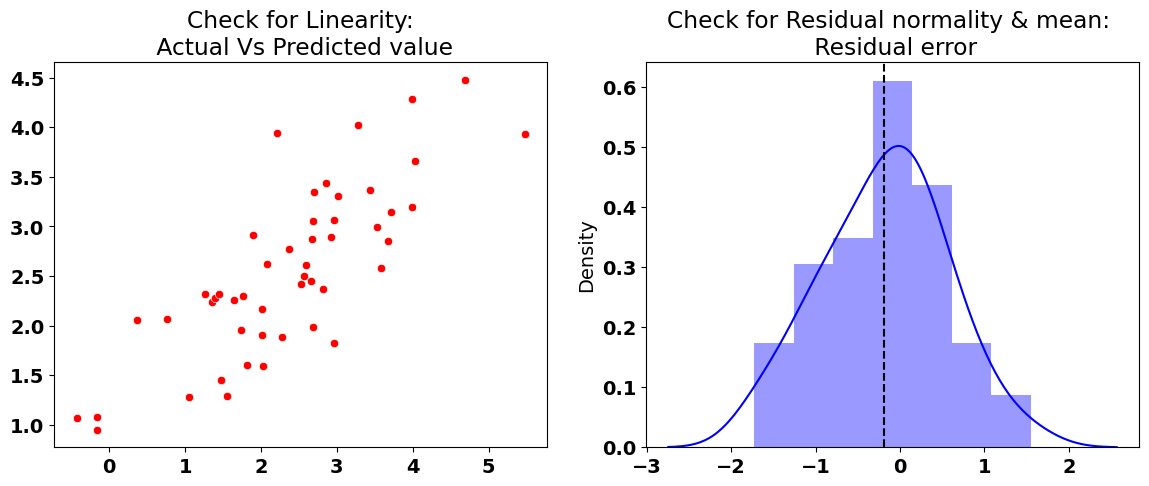

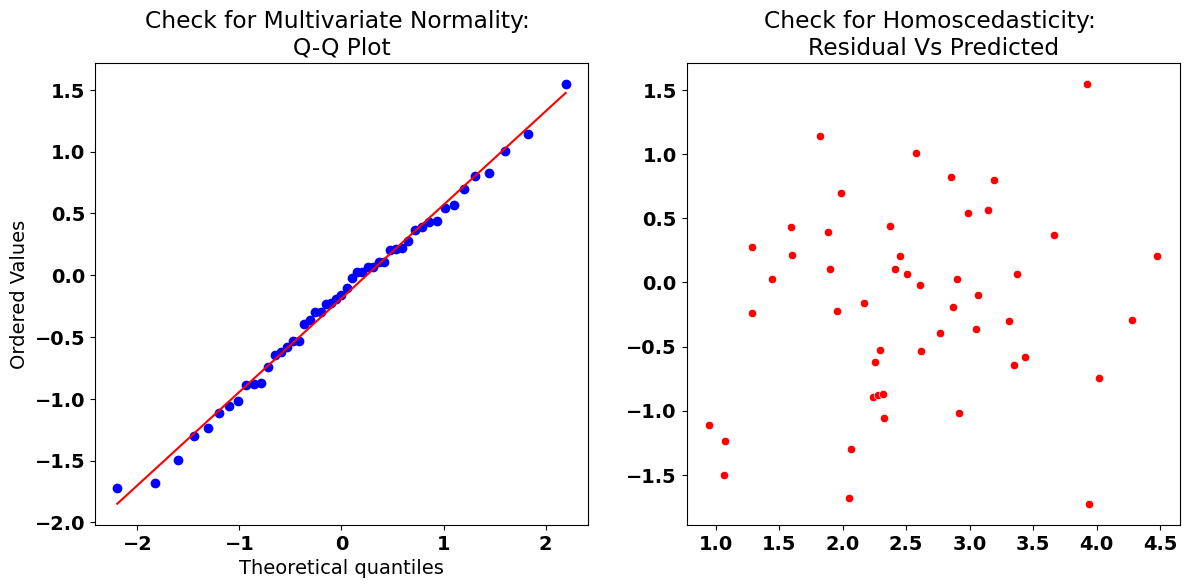

In [ ]:
# sklearn regression module
y_pred_sk = lin_reg.predict(X_Test)

# Check for Linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
sns.scatterplot(x=Y_Test,y=y_pred_sk,ax=ax,color='r')
ax.set_title('Check for Linearity:\n Actual Vs Predicted value')

# Check for Residual normality & mean
ax = f.add_subplot(122)
sns.distplot((Y_Test - y_pred_sk),ax=ax,color='b')
ax.axvline((Y_Test - y_pred_sk).mean(),color='k',linestyle='--')
ax.set_title('Check for Residual normality & mean: \n Residual error');

# Check for Multivariate Normality
# Quantile-Quantile plot 
f,ax = plt.subplots(1,2,figsize=(14,6))
import scipy as sp
_,(_,_,r)= sp.stats.probplot((Y_Test - y_pred_sk),fit=True,plot=ax[0])
ax[0].set_title('Check for Multivariate Normality: \nQ-Q Plot')

#Check for Homoscedasticity
sns.scatterplot(y = (Y_Test - y_pred_sk), x= y_pred_sk, ax = ax[1],color='r') 
ax[1].set_title('Check for Homoscedasticity: \nResidual Vs Predicted');

# Check for Multicollinearity
#Variance Inflation Factor -> has to be > 5
VIF = 1/(1- 0.694)
VIF
 


7. RIDGE REGRESSION

{'alpha': 1e-15}
-0.8236592331233759


2.59656530625

array(['lcavol', 'lweight', 'svi', 'gleason'], dtype=object)

array([ 0.61748985,  0.18392159,  0.26688536, -0.01656346])

3.26797385620915

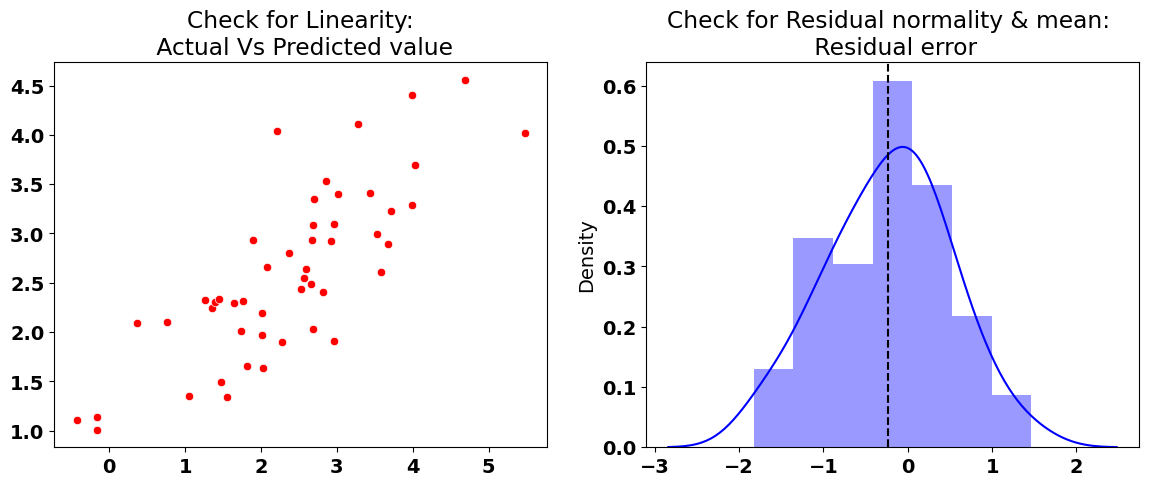

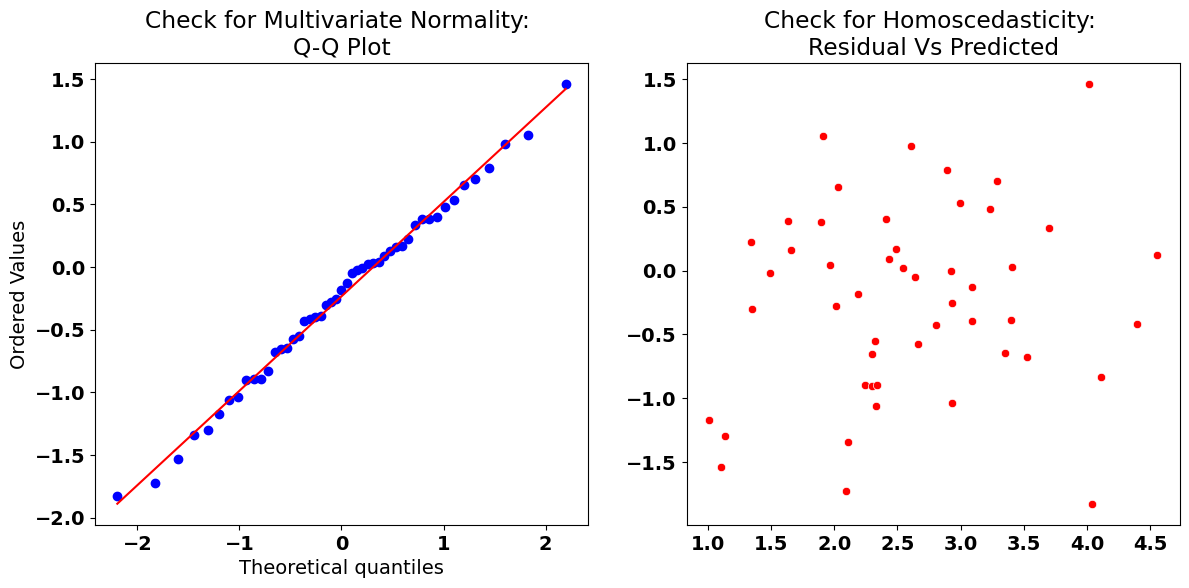

In [ ]:
# Columns to drop
colsToDrop = ['lpsa','TrainTestFlag','age','lbph','pgg45','lcp'] 
X_Train = trainSample.drop(columns = colsToDrop, axis=1)
X_Test = testSample.drop(columns = colsToDrop, axis=1)

# Prepare Train Sample

# Features scaling
if True:
    cols = X_Train.columns

    for i in range(len(cols)):
        # Z-Score using scipy 
        X_Train[cols[i]] = stats.zscore(X_Train[cols[i]]) 

Y_Train= trainSample['lpsa'].values

# Prepare Test Sample

if True:
    cols = X_Test.columns
    # Feautures scaling
    for i in range(len(cols)):
        # Z-Score using scipy 
        X_Test[cols[i]] = stats.zscore(X_Test[cols[i]]) 

Y_Test= testSample['lpsa'].values


parameters = {"alpha":[1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}
ridge_regression = GridSearchCV(Ridge(), parameters, scoring='neg_mean_squared_error', cv=5)
ridge_regression.fit(X_Train, Y_Train)

print(ridge_regression.best_params_)
print(ridge_regression.best_score_)

ridge_reg = Ridge(alpha=1e-15, solver='cholesky')
ridge_reg.fit(X_Train,Y_Train)
display(ridge_reg.intercept_)
display(ridge_reg.feature_names_in_)
display(ridge_reg.coef_)
y_pred_sk = ridge_reg.predict(X_Test)

# Check for Linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
sns.scatterplot(x=Y_Test,y=y_pred_sk,ax=ax,color='r')
ax.set_title('Check for Linearity:\n Actual Vs Predicted value')

# Check for Residual normality & mean
ax = f.add_subplot(122)
sns.distplot((Y_Test - y_pred_sk),ax=ax,color='b')
ax.axvline((Y_Test - y_pred_sk).mean(),color='k',linestyle='--')
ax.set_title('Check for Residual normality & mean: \n Residual error');

# Check for Multivariate Normality
# Quantile-Quantile plot 
f,ax = plt.subplots(1,2,figsize=(14,6))
import scipy as sp
_,(_,_,r)= sp.stats.probplot((Y_Test - y_pred_sk),fit=True,plot=ax[0])
ax[0].set_title('Check for Multivariate Normality: \nQ-Q Plot')

#Check for Homoscedasticity
sns.scatterplot(y = (Y_Test - y_pred_sk), x= y_pred_sk, ax = ax[1],color='r') 
ax[1].set_title('Check for Homoscedasticity: \nResidual Vs Predicted');

# Check for Multicollinearity
#Variance Inflation Factor -> has to be > 5
VIF = 1/(1- 0.694)
VIF



8 LASSO REGRESSION

{'alpha': 1e-10}
-0.8236592330962649


2.59656530625

array(['lcavol', 'lweight', 'svi', 'gleason'], dtype=object)

array([ 0.61748985,  0.18392159,  0.26688536, -0.01656346])

3.26797385620915

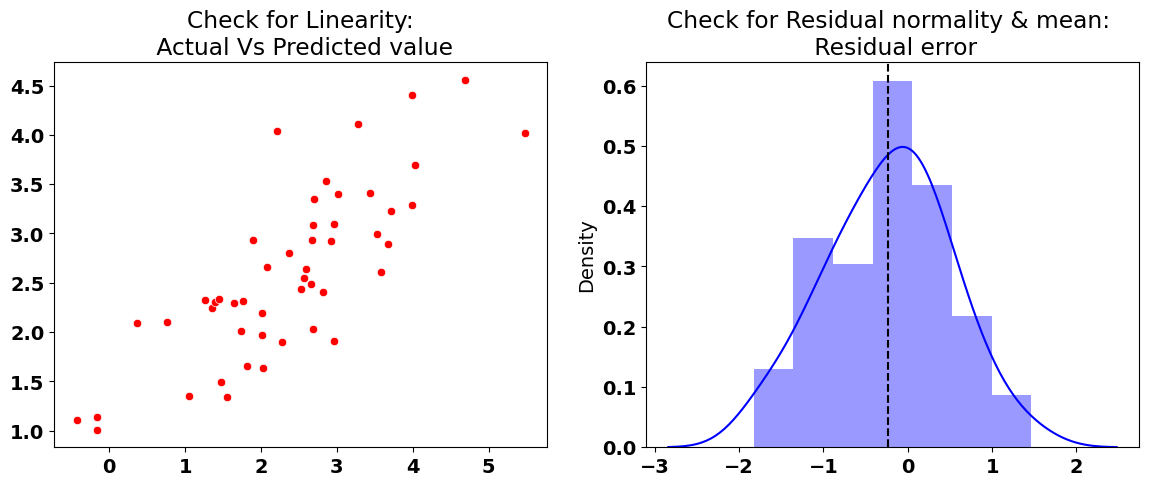

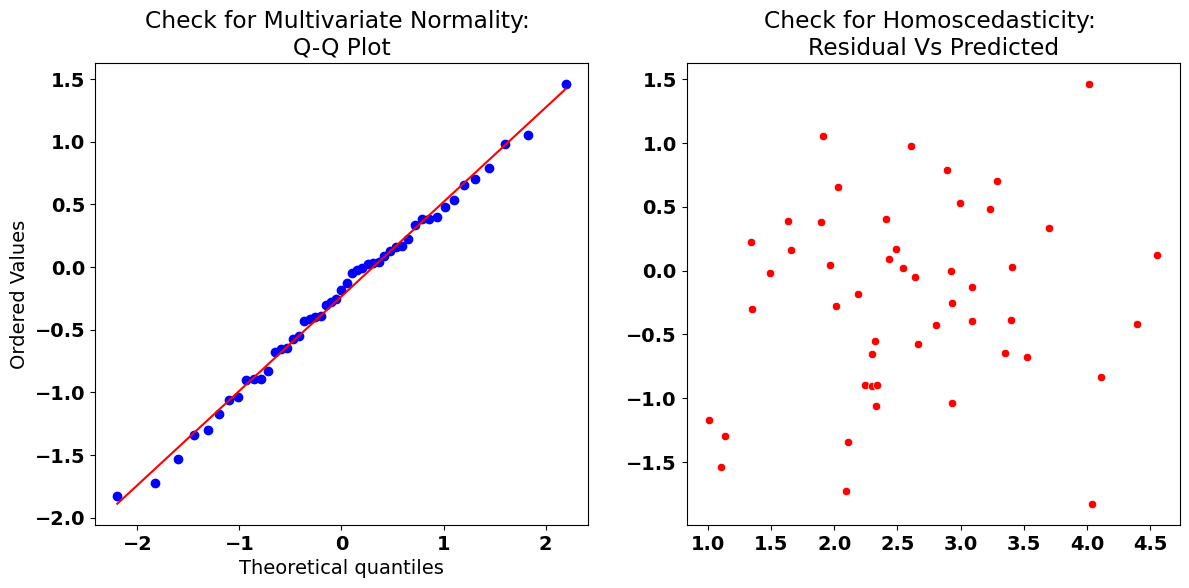

In [ ]:
# Columns to drop
colsToDrop = ['lpsa','TrainTestFlag','age','lbph','pgg45','lcp'] 
X_Train = trainSample.drop(columns = colsToDrop, axis=1)
X_Test = testSample.drop(columns = colsToDrop, axis=1)


# Features scaling
if True:
    cols = X_Train.columns

    for i in range(len(cols)):
        # Z-Score using scipy 
        X_Train[cols[i]] = stats.zscore(X_Train[cols[i]]) 

Y_Train= trainSample['lpsa'].values

# Prepare Test Sample

if True:
    cols = X_Test.columns
    # Feautures scaling
    for i in range(len(cols)):
        # Z-Score using scipy 
        X_Test[cols[i]] = stats.zscore(X_Test[cols[i]]) 

Y_Test= testSample['lpsa'].values

lasso = Lasso()

parameters = {"alpha":[1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}
lasso_regression = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_regression.fit(X_Train, Y_Train)

print(lasso_regression.best_params_)
print(lasso_regression.best_score_)

lasso_reg = Lasso(alpha=1e-15)
lasso_reg.fit(X_Train,Y_Train)
display(lasso_reg.intercept_)
display(lasso_reg.feature_names_in_)
display(lasso_reg.coef_)


y_pred_sk = lasso_reg.predict(X_Test)

# Check for Linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
sns.scatterplot(x=Y_Test,y=y_pred_sk,ax=ax,color='r')
ax.set_title('Check for Linearity:\n Actual Vs Predicted value')

# Check for Residual normality & mean
ax = f.add_subplot(122)
sns.distplot((Y_Test - y_pred_sk),ax=ax,color='b')
ax.axvline((Y_Test - y_pred_sk).mean(),color='k',linestyle='--')
ax.set_title('Check for Residual normality & mean: \n Residual error');

# Check for Multivariate Normality
# Quantile-Quantile plot 
f,ax = plt.subplots(1,2,figsize=(14,6))
import scipy as sp
_,(_,_,r)= sp.stats.probplot((Y_Test - y_pred_sk),fit=True,plot=ax[0])
ax[0].set_title('Check for Multivariate Normality: \nQ-Q Plot')

#Check for Homoscedasticity
sns.scatterplot(y = (Y_Test - y_pred_sk), x= y_pred_sk, ax = ax[1],color='r') 
ax[1].set_title('Check for Homoscedasticity: \nResidual Vs Predicted');

# Check for Multicollinearity
#Variance Inflation Factor -> has to be > 5
VIF = 1/(1- 0.694)
VIF


